In [1]:
import anndata
import scanpy as sc
import pandas as pd
from scipy import sparse
from modules.process_data import *
from collections import Counter
from matplotlib.ticker import PercentFormatter
from modules.utils import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.multitest import multipletests
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-06 09:41:43.285602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 09:41:43.836751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 1
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = 2
#adata3 = anndata.read_h5ad("data/C_count.h5ad")
#adata3.obs['Sample_Tag'] = 3
#adata4 = anndata.read_h5ad("data/D_count.h5ad")
#adata4.obs['Sample_Tag'] = 4
#adata = anndata.concat([adata1, adata2], axis=0)

In [3]:
adata1 = rm_high_mt(adata1, threshold=0.3)
adata1 = filter_cells_by_gene_counts(adata1)

sc.pp.normalize_total(adata1, target_sum=1, exclude_highly_expressed=True, max_fraction=0.2)
#sc.pp.log1p(adata1)
#sc.pp.scale(adata1)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
adata2 = rm_high_mt(adata2, threshold=0.3)
adata2 = filter_cells_by_gene_counts(adata2)

sc.pp.normalize_total(adata2, target_sum=1, exclude_highly_expressed=True, max_fraction=0.2)
#sc.pp.log1p(adata2)
#sc.pp.scale(adata2)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
adata1_df = pd.DataFrame(adata1.X.toarray() if hasattr(adata1.X, 'toarray') else adata1.X, index=adata1.obs_names, columns=adata1.var_names)
adata2_df = pd.DataFrame(adata2.X.toarray() if hasattr(adata2.X, 'toarray') else adata2.X, index=adata2.obs_names, columns=adata2.var_names)

In [6]:
common_cols = list(set(adata1_df.columns) & set(adata2_df.columns))
adata1_df = adata1_df[common_cols]
adata2_df = adata2_df[common_cols]

In [7]:
# Initialize lists to store the gene names, fold changes, and p-values
gene_names = []
fold_changes = []
p_values = []
log10_pvals = []

# Iterate over each gene (column) in the DataFrames
for gene in tqdm(adata1_df.columns):
    # Get the expression values for this gene in both datasets
    fad_values = adata1_df[gene].values
    nc_values = adata2_df[gene].values

    # Perform the t-test
    t_stat, p_value = ttest_ind(fad_values, nc_values, equal_var=False)

    # Calculate the fold change
    mean_fad = np.mean(fad_values)
    mean_nc = np.mean(nc_values)

    fold_change = np.log2(np.nan_to_num(np.divide(mean_fad, mean_nc), nan=1))

    #p_value = max(p_value, 1e-300)
    log10_pval = -np.log10(p_value)

    # Store the results
    gene_names.append(gene)
    fold_changes.append(fold_change)
    p_values.append(p_value)
    log10_pvals.append(log10_pval)


  1%|▌                                     | 438/30082 [00:00<00:34, 866.58it/s]/tmp/ipykernel_19199/3533209816.py:20: RuntimeWarning: divide by zero encountered in divide
  fold_change = np.log2(np.nan_to_num(np.divide(mean_fad, mean_nc), nan=1))
  2%|▋                                     | 525/30082 [00:00<00:34, 858.73it/s]/tmp/ipykernel_19199/3533209816.py:23: RuntimeWarning: divide by zero encountered in log10
  log10_pval = -np.log10(p_value)
 10%|███▊                                 | 3109/30082 [00:03<00:47, 564.84it/s]/tmp/ipykernel_19199/3533209816.py:20: RuntimeWarning: divide by zero encountered in log2
  fold_change = np.log2(np.nan_to_num(np.divide(mean_fad, mean_nc), nan=1))
100%|████████████████████████████████████| 30082/30082 [00:34<00:00, 864.69it/s]


In [8]:
# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Gene': gene_names,
    'log2_fold_change': fold_changes,
    'p-value': p_values,
    'log10_p-value': log10_pvals
})

In [9]:
# Assuming result_df is a pandas DataFrame with the necessary data
fold_change = results_df['log2_fold_change']
p_value = results_df['p-value']
log10_pvalue = -np.log10(p_value)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# Define significant genes
significant = p_value < 0.05
non_significant = ~significant
significant_outside_range = significant & ((fold_change > 1) | (fold_change < -1))
significant_inside_range = significant & ((fold_change >= -1) & (fold_change <= 1))

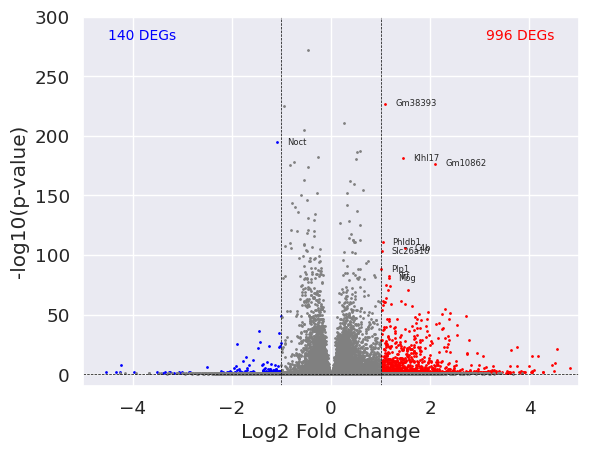

In [17]:
# Exclude genes with log10 p-value of infinity
finite_log10_pvalue = log10_pvalue != np.inf

# Get the top 20 significant genes outside the range -1 to 1 for cleaner annotation
top_genes = results_df[significant_outside_range & finite_log10_pvalue].nlargest(10, 'log10_p-value')

# Create the volcano plot
plt.scatter(fold_change[significant_outside_range & (fold_change > 0)], log10_pvalue[significant_outside_range & (fold_change > 0)], s=1, c='red')
plt.scatter(fold_change[significant_outside_range & (fold_change <= 0)], log10_pvalue[significant_outside_range & (fold_change <= 0)], s=1, c='blue')
plt.scatter(fold_change[non_significant | significant_inside_range], log10_pvalue[non_significant | significant_inside_range], s=1, c='grey')

# Add dotted lines
plt.axvline(x=-1, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Annotate the top genes
for _, row in top_genes.iterrows():
    plt.annotate(row['Gene'], (row['log2_fold_change'] + 0.2, -np.log10(row['p-value'])), ha='left', va='center', fontsize=6)

# Count and annotate DEGs
positive_deg_num = (significant_outside_range & (fold_change > 0)).sum()
negative_deg_num = (significant_outside_range & (fold_change <= 0)).sum()

plt.annotate(f'{positive_deg_num} DEGs', xy=(4.5, 290), ha='right', va='top', fontsize=10, color='red')
plt.annotate(f'{negative_deg_num} DEGs', xy=(-4.5, 290), ha='left', va='top', fontsize=10, color='blue')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.xlim(-5, 5)
plt.ylim(-10, 300)

plt.savefig('volcano_plot.png')
plt.show()

In [12]:
positive_deg = results_df[(results_df["p-value"] < 0.05) & (results_df["log2_fold_change"] > 1)]['Gene'].tolist()
positive_deg = [x.upper() for x in positive_deg]

negative_deg = results_df[(results_df["p-value"] < 0.05) & (results_df["log2_fold_change"] <= -1)]['Gene'].tolist()
negative_deg = [x.upper() for x in negative_deg]

In [13]:
with open('positive_deg', 'w') as file:
    for gene in positive_deg:
        file.write(gene + '\n')

with open('negative_deg', 'w') as file:
    for gene in negative_deg:
        file.write(gene + '\n')

In [18]:
tsv_file_path = 'positive_go.txt'
df = pd.read_csv(tsv_file_path, delimiter='\t', skiprows=11)

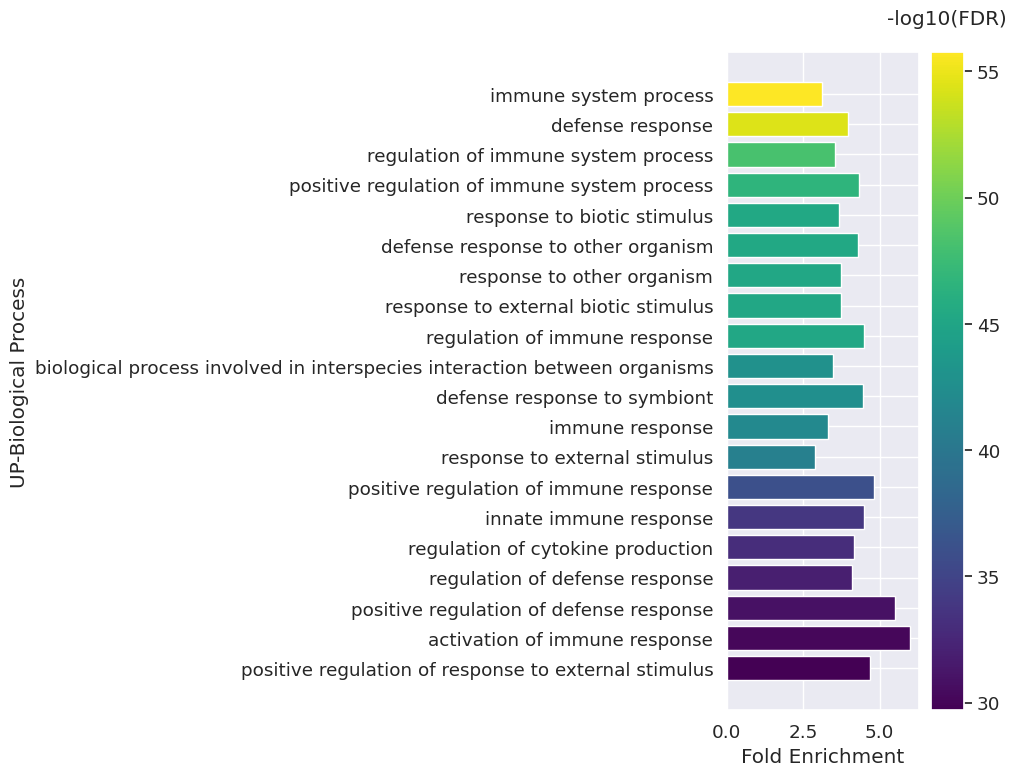

In [19]:
df['upload_1 (fold Enrichment)'] = pd.to_numeric(df['upload_1 (fold Enrichment)'], errors='coerce')
df['upload_1 (FDR)'] = pd.to_numeric(df['upload_1 (FDR)'], errors='coerce')

df = df.dropna(subset=['upload_1 (fold Enrichment)', 'upload_1 (FDR)'])

df = df[df['upload_1 (fold Enrichment)'] >= 1]

df['-log10(FDR)'] = -np.log10(df['upload_1 (FDR)'])

top_processes = df.nlargest(20, '-log10(FDR)')

top_processes['GO biological process complete'] = top_processes['GO biological process complete'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

top_processes = top_processes.sort_values(by='-log10(FDR)', ascending=False)

plt.figure(figsize=(10, 8))
norm = plt.Normalize(top_processes['-log10(FDR)'].min(), top_processes['-log10(FDR)'].max())
colors = plt.cm.viridis(norm(top_processes['-log10(FDR)']))
bars = plt.barh(top_processes['GO biological process complete'], top_processes['upload_1 (fold Enrichment)'], color=colors)

plt.xlabel('Fold Enrichment')
plt.ylabel('UP-Biological Process')
plt.gca().invert_yaxis()  # To display the highest -log10(FDR) at the top

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.ax.set_title('-log10(FDR)', pad=20)

plt.tight_layout()
plt.savefig('up_bio_process.png')
plt.show()

In [14]:
positive_deg = significant & (fold_change >= 1)
negative_deg = significant & (fold_change <= -1)

positive_deg = results_df[positive_deg].nlargest(100, 'log10_p-value')['Gene'].tolist()
negative_deg = results_df[negative_deg].nlargest(100, 'log10_p-value')['Gene'].tolist()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


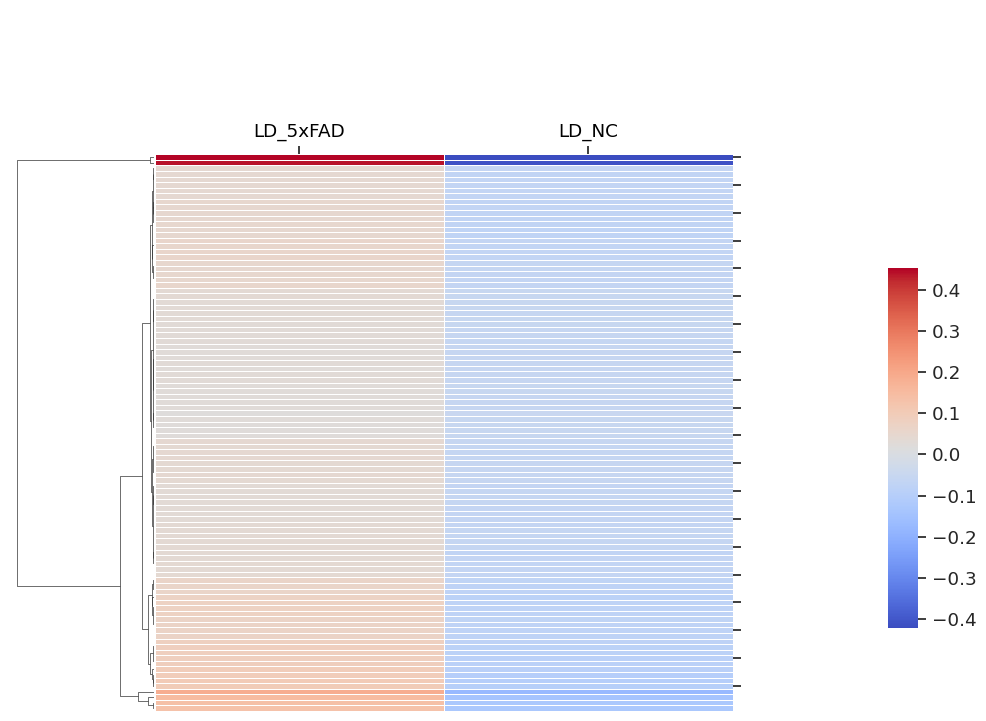

In [15]:
adata1_subset = adata1[:, positive_deg].copy()
adata2_subset = adata2[:, positive_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'LD_5xFAD', 'LD_NC'

combined_adata = anndata.concat([adata1_subset, adata2_subset])
sc.pp.scale(combined_adata, max_value=10)

mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr, cmap='coolwarm', linewidths=.5, figsize=(10, 8), row_cluster=True, col_cluster=False)

cg.ax_heatmap.set_yticklabels([])
cg.cax.set_position([0.9, .2, .03, .45]) 
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)
plt.savefig('positive_heatmap.png', bbox_inches='tight')
plt.show()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


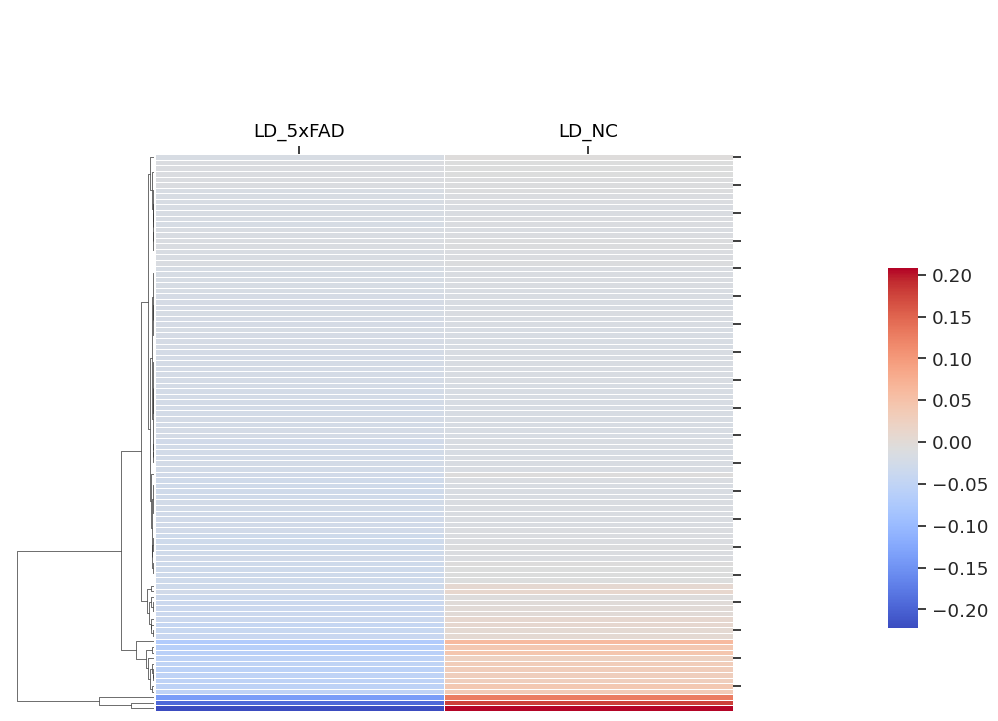

In [16]:
adata1_subset = adata1[:, negative_deg].copy()
adata2_subset = adata2[:, negative_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'LD_5xFAD', 'LD_NC'

combined_adata = anndata.concat([adata1_subset, adata2_subset])
sc.pp.scale(combined_adata, max_value=10)

mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr, cmap='coolwarm', linewidths=.5, figsize=(10, 8), row_cluster=True, col_cluster=False)

cg.ax_heatmap.set_yticklabels([])
cg.cax.set_position([0.9, .2, .03, .45]) 
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)
plt.savefig('negative_heatmap.png', bbox_inches='tight')
plt.show()